In [1]:
from dedalus_sphere import jacobi as Jacobi

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

np.set_printoptions(precision=4,suppress=True)

# Add '../' to path
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import geometric_boussinesq as operators

### The Orthogonal Basis
$$ \psi_{m,l,k}(s,\phi,\eta) = e^{i m \phi} P_l(\eta) s^m (1-s^2)^\frac{l}{2} P_k^{l+\frac{1}{2},m}(2s^2 -1)$$

In [2]:
ns, neta = 500, 501
s, eta = np.linspace(0,1,ns), np.linspace(-1,1,neta)

g_disable_basis_plots = True

In [3]:
def plotfield(s, eta, f, fig=None, ax=None, stretch=False):
    s, eta = s.ravel(), eta.ravel()
    ss = np.reshape(s,(1,len(s)))
    ee = np.reshape(eta,(len(eta),1))
    zz = np.sqrt(1-ss**2)*ee
    y = ee if stretch else zz
    
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(4.25,6))
    im = ax.pcolormesh(ss, y, f, cmap='RdBu')
    fig.colorbar(im, ax=ax)
    ax.set_xlabel('s')
    if stretch:
        ax.set_ylabel('η')
    else:
        ax.set_ylabel('z')
    ax.set_aspect('equal', adjustable='box')
    fig.set_tight_layout(True)


def expansion(F, T, Q):
    return T @ (Q @ F).T

def plot_basis(basis, s, eta):
    Nmax = len(basis)
    ncols = 3
    nrows = (Nmax+ncols-1)//ncols
    fig, plot_axes = plt.subplots(nrows,ncols,figsize=(11,4*nrows))
    row, col = 0, 0
    for k in range(Nmax):
        plotfield(s, eta, basis[k], fig, plot_axes[row][col])
        col += 1
        if col == ncols:
            col = 0
            row += 1

def plot_radial(basis, s, eta, etavalues):
    if np.isscalar(etavalues): etavalues = [etavalues]
    neta = len(etavalues)

    fig, plot_axes = plt.subplots(1,neta,figsize=(4*neta,4))
    if neta == 1: plot_axes = [plot_axes]
    for i in range(neta):
        etaindex = np.argmin(np.abs(eta-etavalues[i]))
        for k in range(len(basis)):
            plot_axes[i].plot(s,basis[k][etaindex,:])
        plot_axes[i].grid()
        plot_axes[i].set_title('ell = {}, η = {}'.format(ell, eta[etaindex]))
        plot_axes[i].set_xlabel('s')
        plot_axes[i].grid(True)


In [4]:
def psi(Nmax, m, ell, s, eta, sigma=0, alpha=0, beta=0):
    ns, neta = len(s), len(eta)
    t = 2*s**2 - 1

    Peta = Jacobi.polynomials(ell+1,alpha,alpha,eta)[-1,:].reshape(neta,1)
    Ps = Jacobi.polynomials(Nmax,ell+alpha+beta+1/2,m+sigma,t)
    tt = t.reshape(1,ns)
    return [Peta * (1+tt)**((m+sigma)/2) * (1-tt)**(ell/2) * Ps[k,:] for k in range(Nmax)]


In [5]:
Nmax, m, ell = 6, 1, 0
basis = psi(Nmax, m, ell, s, eta)

if not g_disable_basis_plots:
    plot_basis(basis, s, eta)
    plot_radial(basis, s, eta, [0.0, 0.5, 1.0])

In [6]:
Nmax, m, ell = 6, 1, 1
basis = psi(Nmax, m, ell, s, eta)

if not g_disable_basis_plots:
    plot_basis(basis, s, eta)
    plot_radial(basis, s, eta, [0.5, 1.0])

In [7]:
Nmax, m, ell = 6, 1, 2
basis = psi(Nmax, m, ell, s, eta)

if not g_disable_basis_plots:
    plot_basis(basis, s, eta)
    plot_radial(basis, s, eta, [0., 0.5, 1.0])

In [8]:
Nmax, m, ell = 6, 1, 3
basis = psi(Nmax, m, ell, s, eta)

if not g_disable_basis_plots:
    plot_basis(basis, s, eta)
    plot_radial(basis, s, eta, [0.5, 1.0])

In [9]:
Nmax, m, ell = 6, 1, 4
basis = psi(Nmax, m, ell, s, eta)

if not g_disable_basis_plots:
    plot_basis(basis, s, eta)
    plot_radial(basis, s, eta, [0., 0.5, 1.0])

### The Gradient

Let $t = 2s^2 - 1$.
Then for a scalar field given by
$$ \psi_{m,l,k} \left( s=\sqrt{\frac{t+1}{2}},\phi,\eta \right) = e^{i m \phi} P_l(\eta) (1+t)^\frac{m}{2} (1-t)^\frac{l}{2} P_k^{l+\frac{1}{2},m}(t)$$
the gradient is found to be
\begin{align}
\left( e_s - i e_\phi \right) \cdot \psi_{m,l,k} &= (1+t)^{\frac{m-1}{2}} (1-t)^{\frac{l-2}{2}} \left[ (1+t) P_k^{(l+\frac{1}{2},m)}(t) \left( (l+1)P_l(\eta) + \eta P_l'(\eta) \right) - 2 P_l(\eta) D^\dagger P_k^{(l+\frac{1}{2}, m)}(t) \right] \\
\left( e_s + i e_\phi \right) \cdot \psi_{m,l,k} &= (1+t)^{\frac{m+1}{2}} (1-t)^{\frac{l-2}{2}} \left[ \hphantom{(1+t)} P_k^{(l+\frac{1}{2},m)}(t) \left( (l+1)P_l(\eta) + \eta P_l'(\eta) \right) - 2 P_l(\eta) C^\dagger P_k^{(l+\frac{1}{2},m)}(t) \right] \\
e_z \cdot \psi_{m,l,k} &= \sqrt{2} (1+t)^{\frac{m}{2}} (1-t)^{\frac{l-1}{2}} P_k^{(l+\frac{1}{2}, m)}(t) P_l'(\eta)
\end{align}



In [10]:
# We need to kron things out but the n matrices depend on ell
import scipy.sparse as sparse

A = Jacobi.operator('A')
B = Jacobi.operator('B')
C = Jacobi.operator('C')
D = Jacobi.operator('D')
Z = Jacobi.operator('Z')
Id = Jacobi.operator('Id')


In [11]:
# Expand the coefficient vector to grid space
def expand(basis, coeffs):
    f = 0*basis[0][0]
    for ell in range(len(basis)):
        for k in range(len(basis[ell])):
            f += coeffs[ell,k] * basis[ell][k]
    return f


zeros in Rp
62
69
zeros in Rm
71
79
zeros in Rz
63
71
78
79
86
87


[None, None, None, None, None, None]

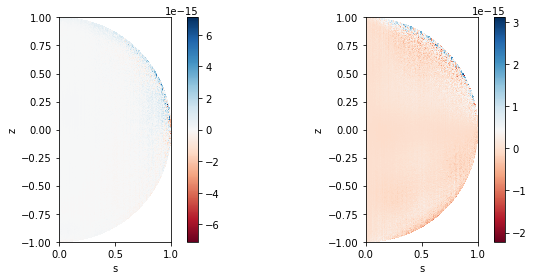

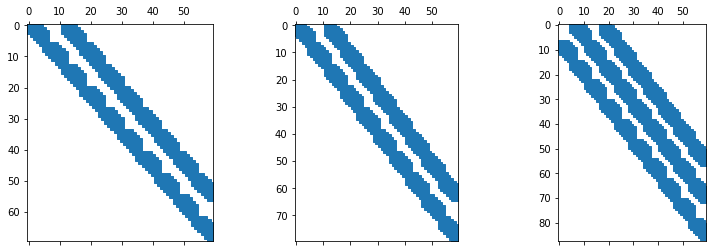

In [21]:
Lmax, Nmax = 10, 6
m, alpha = 1, 0

ns, neta = 256, 255
s = np.linspace(0,1,ns)
t = 2*s**2 - 1
eta = np.linspace(-1,1,neta)
basis = [psi(Nmax, m, ell, s, eta, sigma=0, alpha=alpha) for ell in range(Lmax)]
upbasis = [psi(Nmax+1, m, ell, s, eta, sigma=+1, alpha=alpha+1) for ell in range(Lmax)]
umbasis = [psi(Nmax+2, m, ell, s, eta, sigma=-1, alpha=alpha+1) for ell in range(Lmax)]
uzbasis = [psi(Nmax+2, m, ell, s, eta, sigma= 0, alpha=alpha+1) for ell in range(Lmax+1)]

F = 1/(np.arange(1,Lmax+1).reshape(Lmax,1)*np.arange(1,Nmax+1))
f = expand(basis, F)

s, eta = s.reshape(1,ns), eta.reshape(neta,1)
z = np.sqrt(1-s**2)*eta
us_grid = s * f
uz_grid = z * f

Rops, Rcodomains = operators.make_r_multiplication_operator(m, Lmax, Nmax, alpha)

Fp = (Rops[0] @ F.ravel()).reshape(Rcodomains[0])
Fm = (Rops[1] @ F.ravel()).reshape(Rcodomains[1])
Fz = (Rops[2] @ F.ravel()).reshape(Rcodomains[2])

up = expand(upbasis, Fp)
um = expand(umbasis, Fm)
uz = expand(uzbasis, Fz)
us = 1/np.sqrt(2) * (up + um)

error_s = us_grid - us
error_z = uz_grid - uz

fig, ax = plt.subplots(1,2,figsize=(9,4))
plotfield(s.ravel(), eta.ravel(), error_s, fig, ax[0], stretch=False)
plotfield(s.ravel(), eta.ravel(), error_z, fig, ax[1], stretch=False)

fig, ax = plt.subplots(1,3,figsize=(13,4))
ax[0].spy(Rops[0])
ax[1].spy(Rops[1])
ax[2].spy(Rops[2])

print('zeros in Rp')
index = 0
[print(i) for i in range(np.shape(Rops[index])[0]) if np.max(np.abs(Rops[index][i,:])) < 1e-12]

print('zeros in Rm')
index = 1
[print(i) for i in range(np.shape(Rops[index])[0]) if np.max(np.abs(Rops[index][i,:])) < 1e-12]

print('zeros in Rz')
index = 2
[print(i) for i in range(np.shape(Rops[index])[0]) if np.max(np.abs(Rops[index][i,:])) < 1e-12]

In [30]:
index = 2
set(range(np.prod(Rcodomains[index])))-set(Rops[index].nonzero()[0])

{63, 71, 78, 79, 86, 87}

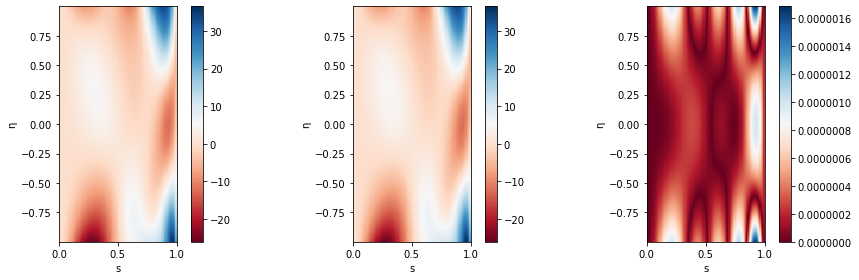

In [13]:
# Test e_z . Grad(psi) the z component of the gradient of a scalar field
Lmax, Nmax, m = 6, 5, 2
ns, neta = 100, 10001

# Construct the hierarchy of bases.  
# The first index is ell (vertical polynomial degree),
# the second index is k (radial polynomial degree)
s, eta = np.linspace(0,1,ns), np.linspace(-1,1,neta)
basis   = [psi(Nmax, m, ell, s, eta, sigma=0, alpha=0) for ell in range(Lmax)]
cobasis = [psi(Nmax, m, ell, s, eta, sigma=0, alpha=1) for ell in range(Lmax-1)]

# Construct the coefficients
c = np.zeros((Lmax,Nmax))
c[0,0] = 1
c[2,2] = 1
c[2,3] = -1
c[3,1] = 1
c[3,3] = .5
c[5,4] = -.1

# Expand the function
f = expand(basis, c)

# Apply the operator in grid space
ss, ee = s.reshape(1,ns), eta.reshape(neta,1)
scale = np.sqrt(1-ss**2)
scale[np.abs(scale) == 0] = 1
fgrid = (f[2:,:]-f[:-2,:])/(ee[2:,:]-ee[:-2,:])/scale

# Apply the operator in coeff space
op = np.sqrt(2) * D(+1)(Lmax,0,0)
d = op @ c
fcoeff = expand(cobasis, d)

# # This is also the operator, explicitly
# ell = np.arange(1,Lmax)
# ratio = Jacobi.norm_ratio(-1,1,1,ell,0,0)
# op = sparse.diags([ratio * (ell+1)/2], [1], shape=(Lmax-1,Lmax))

# Match sizes and compute error
fcoeff = fcoeff[1:-1,:]
eta = eta[1:-1]
error = fgrid-fcoeff

# Plot
fig, ax = plt.subplots(1,3,figsize=(13,4))
plotfield(s, eta, fgrid,  fig, ax[0], stretch=True)
plotfield(s, eta, fcoeff, fig, ax[1], stretch=True)
plotfield(s, eta, np.abs(error),  fig, ax[2], stretch=True)


In [14]:
def make_operator(zmat,smats):
    Lout, Lin = np.shape(zmat)
    Nout, Nin = 0, 0
    for smat in smats:
        if np.ndim(smat) < 2: continue
        sh = np.shape(smat)
        if Nout < sh[0]: Nout = sh[0]
        if Nin  < sh[1]: Nin  = sh[1]
    # Construct the operator matrix
    op = sparse.lil_matrix((Lout*Nout,Lin*Nin))
    rows, cols = zmat.nonzero()
    for row, col in zip(rows, cols):
        value = zmat[row,col]
        if np.abs(value) < 1e-15:
            continue
        smat = smats[col]
        op[Nout*row:Nout*(row+1),Nin*col:Nin*(col+1)] = value * smat
    return op


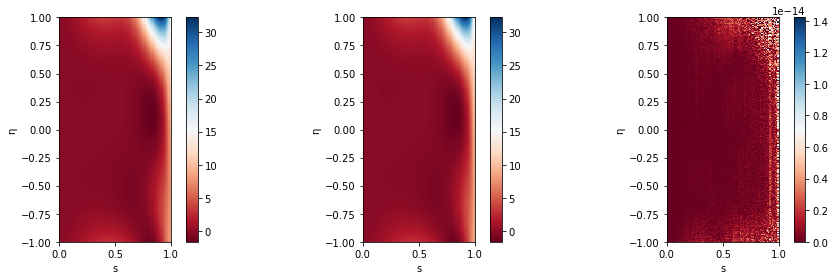

In [15]:
# Spherical radial component e_r . u = 1/2**0.5 *(s u(-) + s u(+)) + eta * (1-s**2)**0.5 * w
Lmax, Nmax, m = 4, 3, 2
ns, neta = 100, 1001
alpha = 1

# Construct the hierarchy of bases.  
# The first index is ell (vertical polynomial degree),
# the second index is k (radial polynomial degree)
s, eta = np.linspace(0,1,ns), np.linspace(-1,1,neta)
upbasis = [psi(Nmax,   m, ell, s, eta, sigma=+1, alpha=alpha) for ell in range(Lmax)]
umbasis = [psi(Nmax,   m, ell, s, eta, sigma=-1, alpha=alpha) for ell in range(Lmax)]
u0basis = [psi(Nmax,   m, ell, s, eta, sigma= 0, alpha=alpha) for ell in range(Lmax)]
cobasis = [psi(Nmax+1, m, ell, s, eta, sigma= 0, alpha=alpha) for ell in range(Lmax+1)]

# Construct the coefficients
# cp = np.ones((Lmax,Nmax))
# cm = np.ones((Lmax,Nmax))
# c0 = np.ones((Lmax,Nmax))
cp = np.random.rand(Lmax,Nmax)
cm = np.random.rand(Lmax,Nmax)
c0 = np.random.rand(Lmax,Nmax)

# Expand the function
up = expand(upbasis, cp)
um = expand(umbasis, cm)
u0 = expand(u0basis, c0)

# Apply the operator in grid space
ss, ee = s.reshape(1,ns), eta.reshape(neta,1)
fgrid = np.sqrt(0.5) * ss * (up + um) + ee * np.sqrt(1-ss**2) * u0

# Coeff space operator: s * u(-)
zmat = sparse.eye(Lmax,Lmax,format='lil')
smats = [B(+1)(Nmax,ell+alpha+1/2,m-1) for ell in range(Lmax)]
Opm = 1/2 * make_operator(zmat,smats)

# Coeff space operator: s * u(+)
zmat = sparse.eye(Lmax,Lmax,format='lil')
smats = [B(-1)(Nmax,ell+alpha+1/2,m+1) for ell in range(Lmax)]
Opp = 1/2 * make_operator(zmat, smats)

# Coeff space operator: z * w = eta * (1-s**2)*0.5 * w
opz = Z(Lmax,alpha,alpha).todense()

zmat = np.diag(np.diag(opz,-1),-1)[:,:Lmax]
smats = [A(+1)(Nmax+1,ell-1+alpha+1/2,m)[:,:Nmax] for ell in range(1,Lmax+1)] + [0]
Opz1 = make_operator(zmat, smats)

zmat = np.concatenate((np.diag(np.diag(opz,+1),+1),np.zeros((1,Lmax))),axis=0)
smats = [0] + [A(-1)(Nmax,ell+1+alpha+1/2,m)[:,:Nmax] for ell in range(Lmax-1)]
Opz2 = make_operator(zmat, smats)

Opz = 1/np.sqrt(2) * (Opz1 + Opz2)

# Apply the operators
dm = (Opm @ cm.ravel()).reshape(Lmax,Nmax)
dp = (Opp @ cp.ravel()).reshape(Lmax,Nmax+1)
d0 = (Opz @ c0.ravel()).reshape(Lmax+1,Nmax+1)

dp = np.concatenate([dp,np.zeros((1,Nmax+1))], axis=0)
dm = np.block([[dm,np.zeros((Lmax,1))],[np.zeros((1,Nmax+1))]])
d = dp + dm + d0
fcoeff = expand(cobasis, d)

# Compute error
error = fgrid-fcoeff
assert np.max(abs(error)) < 5e-14

# Plot
fig, ax = plt.subplots(1,3,figsize=(13,4))
plotfield(s, eta, fgrid,  fig, ax[0], stretch=True)
plotfield(s, eta, fcoeff, fig, ax[1], stretch=True)
plotfield(s, eta, np.abs(error),  fig, ax[2], stretch=True)

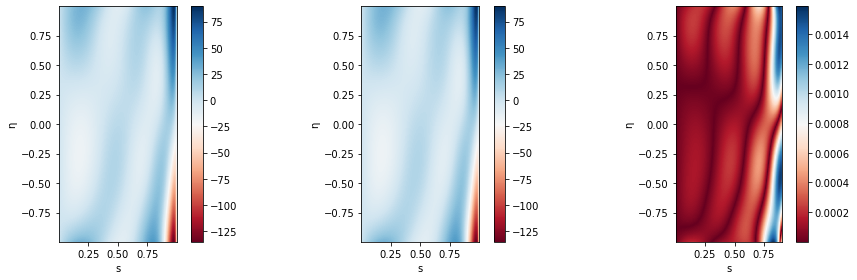

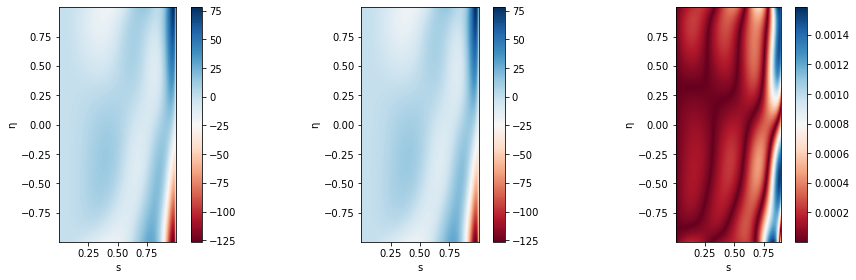

In [16]:
# Test 1/sqrt(2) * (e_s \pm i e_{phi}) . Grad(psi) the z component of the gradient of a scalar field
Lmax, Nmax, m = 6, 5, 2
ns, neta = 1001, 1001

# Construct the hierarchy of bases.  
# The first index is ell (vertical polynomial degree),
# the second index is k (radial polynomial degree)
s, eta = np.linspace(0,1,ns), np.linspace(-1,1,neta)
basis   = [psi(Nmax, m, ell, s, eta, sigma=0, alpha=0) for ell in range(Lmax)]
umbasis = [psi(Nmax+1, m, ell, s, eta, sigma=-1, alpha=1) for ell in range(Lmax)]
upbasis = [psi(Nmax, m, ell, s, eta, sigma=+1, alpha=1) for ell in range(Lmax)]

# Construct the coefficients
c = np.zeros((Lmax,Nmax))
c[0,0] = 1
c[1,4] = 1
c[2,0] = 1
c[2,2] = 1
c[2,3] = -1
c[3,3] = .5
c[5,4] = -.1

# Expand the function
f = expand(basis, c)

# Apply the operator in grid space
ss, ee = s.reshape(1,ns), eta.reshape(neta,1)

dfds = (f[:,2:]-f[:,:-2])/(ss[:,2:]-ss[:,:-2])

scale = 1-ss**2
scale[np.abs(scale) < 1e-12] = 1
dfdeta = (ss/scale)*ee[1:-1,:]*(f[2:,:]-f[:-2,:])/(ee[2:,:]-ee[:-2,:])

scale = ss
scale[np.abs(scale) < 1e-12] = 1
dfdphi = (1/scale * 1j * m * f)

fgridm = 1/np.sqrt(2) * (dfds[1:-1,:] + dfdeta[:,1:-1] - 1j*dfdphi[1:-1,1:-1]).real
fgridp = 1/np.sqrt(2) * (dfds[1:-1,:] + dfdeta[:,1:-1] + 1j*dfdphi[1:-1,1:-1]).real

op = (A(+1) @ B(+1))(Lmax,0,0).todense()
alph = np.diag(op)
beta = -np.diag(op,2)

zmat = np.diag(2*alph)
smats = [np.concatenate((C(+1)(Nmax,ell+1/2,m).todense(),np.zeros((1,Nmax))),axis=0) for ell in range(Lmax)]
Op1 = make_operator(zmat, smats)

zmat = np.diag(2*beta,2)
smats = [D(-1)(Nmax,ell+1/2,m) for ell in range(Lmax)]
Op2 = make_operator(zmat, smats)

# Combined operator
Opm = Op1 + Op2

zmat = np.diag(2*alph)
smats = [np.concatenate((D(+1)(Nmax,ell+1/2,m).todense(),np.zeros((1,Nmax))),axis=0) for ell in range(Lmax)]
Op1 = make_operator(zmat, smats)

zmat = np.diag(2*beta,2)
smats = [C(-1)(Nmax,ell+1/2,m) for ell in range(Lmax)]
Op2 = make_operator(zmat, smats)

# Combined operator
Opp = Op1 + Op2

# Apply the operator to the coefficients
dm = (Opm @ c.ravel()).reshape(Lmax,Nmax+1)
fcoeffm = expand(umbasis, dm)[1:-1,1:-1]

dp = (Opp @ c.ravel()).reshape(Lmax,Nmax)
fcoeffp = expand(upbasis, dp)[1:-1,1:-1]

eta = eta[1:-1]
s = s[1:-1]

errorm = fgridm-fcoeffm
errorp = fgridp-fcoeffp

# Plot
fig, ax = plt.subplots(1,3,figsize=(13,4))
plotfield(s, eta, fgridm,  fig, ax[0], stretch=True)
plotfield(s, eta, fcoeffm, fig, ax[1], stretch=True)
plotfield(s[:-100], eta, np.abs(errorm[:,:-100]),  fig, ax[2], stretch=True)

fig, ax = plt.subplots(1,3,figsize=(13,4))
plotfield(s, eta, fgridp,  fig, ax[0], stretch=True)
plotfield(s, eta, fcoeffp, fig, ax[1], stretch=True)
plotfield(s[:-100], eta, np.abs(errorp[:,:-100]),  fig, ax[2], stretch=True)


In [17]:
# This equation is funky fresh.  It allows the whole thing to work
N = Jacobi.operator('N')
for a in range(3):
    b = a
    op1 = ((A(+1) @ B(+1)) @ (N + (a+b+1)*Id) + Z @ D(+1))(Lmax,a,b).todense()
    op2 = (2*(N+(a+b)/2+1/2) @ (A(+1) @ B(+1)))(Lmax,a,b).todense()
    print(np.diag(op1-op2))


[0. 0. 0. 0. 0. 0.]
[ 0. -0.  0.  0.  0.  0.]
[ 0.  0. -0.  0.  0.  0.]


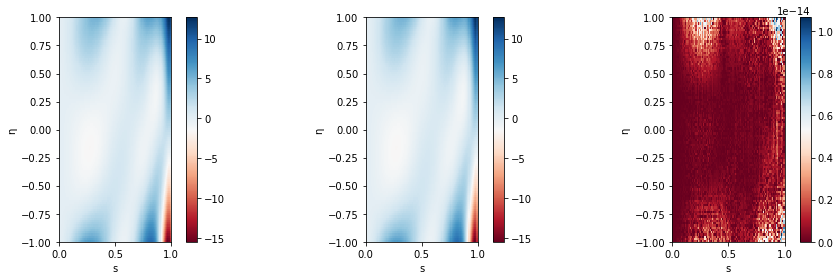

In [18]:
# Conversion operator from alpha = 0 to alpha = 1
Lmax, Nmax, m = 6, 5, 2
ns, neta = 101, 101
alpha = 1

# Construct the hierarchy of bases.  
# The first index is ell (vertical polynomial degree),
# the second index is k (radial polynomial degree)
s, eta = np.linspace(0,1,ns), np.linspace(-1,1,neta)
basis   = [psi(Nmax, m, ell, s, eta, sigma=0, alpha=alpha) for ell in range(Lmax)]
cobasis = [psi(Nmax+1, m, ell, s, eta, sigma=0, alpha=alpha+1) for ell in range(Lmax)]

# Construct the coefficients
c = np.zeros((Lmax,Nmax))
c[0,0] = 1
c[1,4] = 1
c[2,0] = 1
c[2,2] = 1
c[2,3] = -1
c[3,3] = .5
c[5,4] = -.1

# Expand the function
fgrid = expand(basis, c)

# Construct the operator
opz = (A(+1) @ B(+1))(Lmax,alpha,alpha).todense()
alpha_ell = np.diag(opz)
beta_ell = np.diag(opz,2)

zmat = np.diag(alpha_ell)
smats = [sparse.vstack([A(+1)(Nmax,ell+alpha+1/2,m),np.zeros((1,Nmax))]) for ell in range(Lmax)]
Op1 = make_operator(zmat, smats)

zmat = np.diag(beta_ell,2)
smats = [A(-1)(Nmax,ell+alpha+1/2,m) for ell in range(Lmax)]
Op2 = make_operator(zmat, smats)

Op = Op1 + Op2

# Apply the operator
d = (Op @ c.ravel()).reshape(Lmax,Nmax+1)
fcoeff = expand(cobasis, d)
error = fgrid - fcoeff

# Plot
fig, ax = plt.subplots(1,3,figsize=(13,4))
plotfield(s, eta, fgrid,  fig, ax[0], stretch=True)
plotfield(s, eta, fcoeff, fig, ax[1], stretch=True)
plotfield(s, eta, np.abs(error), fig, ax[2], stretch=True)


In [19]:
help(sparse.lil_matrix)

Help on class lil_matrix in module scipy.sparse.lil:

class lil_matrix(scipy.sparse.base.spmatrix, scipy.sparse._index.IndexMixin)
 |  lil_matrix(arg1, shape=None, dtype=None, copy=False)
 |  
 |  Row-based list of lists sparse matrix
 |  
 |  This is a structure for constructing sparse matrices incrementally.
 |  Note that inserting a single item can take linear time in the worst case;
 |  to construct a matrix efficiently, make sure the items are pre-sorted by
 |  index, per row.
 |  
 |  This can be instantiated in several ways:
 |      lil_matrix(D)
 |          with a dense matrix or rank-2 ndarray D
 |  
 |      lil_matrix(S)
 |          with another sparse matrix S (equivalent to S.tolil())
 |  
 |      lil_matrix((M, N), [dtype])
 |          to construct an empty matrix with shape (M, N)
 |          dtype is optional, defaulting to dtype='d'.
 |  
 |  Attributes
 |  ----------
 |  dtype : dtype
 |      Data type of the matrix
 |  shape : 2-tuple
 |      Shape of the matrix
 |  n

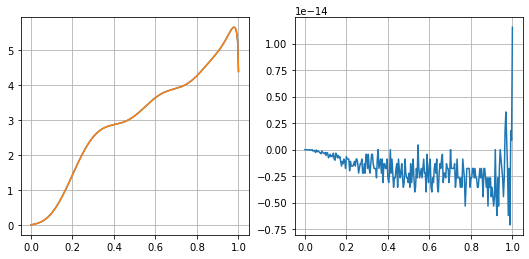

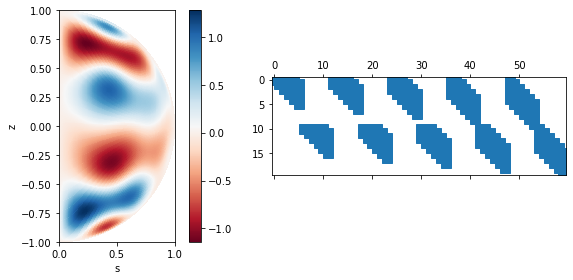

In [20]:
Lmax, Nmax = 10, 6
m, alpha, sigma = 1, 0, 0

s = np.linspace(0,1,256)
t = 2*s**2 - 1
eta = np.array([1.])
basis = [psi(Nmax, m, ell, s, eta, sigma=sigma, alpha=alpha) for ell in range(Lmax)]

F = 1/(np.arange(1,Lmax+1).reshape(Lmax,1)*np.arange(1,Nmax+1))
f = expand(basis, F).ravel()

# Compute the boundary evaluation operator
L = Lmax-1
even_conversions = [(A(+1)**(L//2-ell) @ A(-1)**ell)(Nmax,2*ell+1/2,m) for ell in range(L//2+1)]
odd_conversions = [(A(+1)**(((L-1)//2)-ell) @ A(-1)**ell)(Nmax,2*ell+1+1/2,m) for ell in range((L+1)//2)]

bc = Jacobi.polynomials(Lmax,alpha,alpha,1.)

Opeven = sparse.lil_matrix((Nmax+L//2,Lmax*Nmax))
Opodd  = sparse.lil_matrix((Nmax+(L-1)//2,Lmax*Nmax))
for ell in range(Lmax):
    if ell % 2 == 0:
        op, mat = even_conversions, Opeven
    else:
        op, mat = odd_conversions, Opodd        
    op = bc[ell] * op[ell//2]
    mat[:np.shape(op)[0],ell*Nmax:(ell+1)*Nmax] = op

# Apply the boundary evaluation operator and expand
Feven = (Opeven @ F.ravel())
Fodd = (Opodd @ F.ravel())

cobasis = Jacobi.polynomials(Nmax+L//2,L//2+1/2,m,t).T
feven = cobasis @ Feven

cobasis = Jacobi.polynomials(Nmax+(L-1)//2,(L+1)//2+1/2,m,t).T
fodd = cobasis @ Fodd

fcoeff = (1+t)**(m/2) * (feven + np.sqrt(1-t) * fodd)
error = f - fcoeff

assert np.max(abs(error)) < 2e-14

# Plot the boundary evaluation
fig, plot_axes = plt.subplots(1,2,figsize=(9,4))
plot_axes[0].plot(s, f)
plot_axes[0].plot(s, fcoeff)
plot_axes[1].plot(s, f - fcoeff)
for ax in plot_axes:
    ax.grid()

# Plot a field in the nullspace of the operator, 
# i.e. a field that vanishes on the sphere boundary
Op = sparse.vstack([Opeven,Opodd])
nullspace = sp.linalg.null_space(Op.todense())

eta = np.linspace(-1,1,256)
basis = [psi(Nmax, m, ell, s, eta, sigma=sigma, alpha=alpha) for ell in range(Lmax)]

which = 10
F = nullspace[:,which].reshape(Lmax,Nmax)
f = expand(basis, F)

fig, ax = plt.subplots(1,2,figsize=(9,4))
plotfield(s, eta, f, fig, ax[0], stretch=False)
ax[1].spy(Op)
